# Tutorial III: Fully connected NNs

<p>
Bern Winter School on Machine Learning, 2022<br>
Prepared by Mykhailo Vladymyrov.
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will create a fully-connected neural network to perform handwritten digit recognition using TensorFlow

## 1. Load necessary libraries

In [1]:
colab = True # set to True is using google colab

In [2]:
if colab:
    %tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
import os
import sys
import shutil
import tarfile

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.datasets.mnist as mnist

%load_ext tensorboard

### Download libraries

In [4]:
if colab:
    path = os.path.abspath('.')+'/material.tgz'
    url = 'https://github.com/neworldemancer/BMLWS/raw/main/tut_files/tpub0320.tgz'
    p = tf.keras.utils.get_file(path, url)
    assert p==path
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()

81207979/81207979 [==============================] - 1s 0us/step


In [5]:
from utils import gr_disp

In [6]:
def show_graph(g=None, gd=None):
    gr_disp.show_graph(g, gd)
    %tensorboard --logdir logs

## 2. Training loop

The training as we just saw is done iteratively, by adjusting the model parameters.

We perform optimization several times for all traininng dataset. Going through all this dataset is refered to as 'epoch'.

When we do training its usually done in two loops. In outer loop we iterate over all epochs. For each epoch we usually split the dataset into small chuncks, batches, and optimization it performed for all of those.

It is important that data doesn't go to the training pipeline in same order. So the overall scheme looks like this (pseudocode):


```
x,y = get_training_data()
for epoch in range(number_epochs):
   x_shfl,y_shfl = shuffle(x,y)
   
   for mb_idx in range(number_minibatches_in_batch):
       x_mb,y_mb = get_minibatch(x_shfl,y_shfl, mb_idx)
       
       optimize_on(data=x_mb, labels=y_mb)
```

## 3. Bulding blocks of a neural network

Neural network consists of layers of neurons. Each neuron perfroms 2 operations.

<img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/Perceptron.png" alt="drawing" width="30%"/>

1. Calculate the linear transformation of the input vector $\bar x$: 
$$z = \bar W \cdot \bar x + b = \sum {W_i x_i} + b$$ where $\bar W$ is vector of weights and $b$ - bias.
2. Perform the nonlinear transformation of the result using activation function $f$ $$y = f(z)$$ Here we will use rectified linear unit activation.

In a fully connected neural network each layer is a set of N neurons, performing different transformations of all the same layer's inputs $\bar x = [x_i]$ producing output vector $\bar y = [y_j]_{i=1..N}$: $$y_j = f(\bar W_j \cdot \bar x + b_j)$$

Since output of each layer forms input of next layer, one can write for layer $l$: $$x^l_j = f(\bar W^l_j \cdot \bar x^{l-1} + b^l_j)$$ where $\bar x^0$ is network's input vactor.

<img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/MLP.png" alt="drawing" width="50%"/>

Note: if we would only allow linear transformations, we could collapse the whole thing to just one neuron --> strength is nonlinearity

To simplify building the network, we'll define a helper function, creating neuron layer with given number of outputs:

In [ ]:
#tf.keras.layers.Dense??

In [8]:
class Dense(tf.keras.layers.Layer):
  def __init__(self,
               units,
               activation=None,
               ):
    """Fully connected layer.

    Parameters
    ----------
    units : int
        Number of output neurons
    name : None, optional
        TF Scope to apply
    activation : None, optional
        Non-linear activation function

    Returns
    -------
    h, W : tf.Tensor, tf.Tensor
        Output of the fully connected layer and the weight matrix
    """
    super(self).__init__(**kwargs)
    self.units = int(units)
    self.activation = activations.get(activation)

  def build(self, input_shape):
    input_shape = tf.TensorShape(input_shape)
    last_dim = tf.compat.dimension_value(input_shape[-1])

    self.kernel = self.add_weight(
        'kernel',
        shape=[last_dim, self.units],
        initializer=self.kernel_initializer,
        dtype=self.dtype,
        trainable=True)
    

    self.bias = self.add_weight(
          'bias',
          shape=[self.units,],
          initializer=self.bias_initializer,
          dtype=self.dtype,
          trainable=True)

  def call(self, inputs):
    outputs = tf.matmul(a=inputs, b=self.kernel)
    outputs = tf.nn.bias_add(outputs, self.bias)

    if self.activation is not None:
      outputs = self.activation(outputs)

      return outputs


In the case of classification, in the the last layer we use *softmax* transformation as non-linear transformation: $$y_i = \sigma(\bar z)_i = \frac{ e^{z_i}}{\sum_j e^{z_j}}$$

--> normalization, sums up to 1

This will correspond to the one-hot labels that we use.
Finally we will use the cross entropy between output $y$ and the ground truth (GT) $y_{GT}$ as the loss function: $$H(y, y_{GT}) = - \sum_i y_{GT, i} \log(y_{i})$$

one-hot coding --> form of dummy coding, each classification class gets a 1 in only one of a vector of length n of classifications

## 4. Structure of a neural network

In [9]:
n_input = 10
n_output = 2

In [10]:
x = tf.keras.layers.Input(name='X', dtype=tf.float32, shape=[n_input])

#layer 1: 10 inputs -> 4, sigmoid activation
l1 = tf.keras.layers.Dense(units=4, name='L1', activation='sigmoid')(x)

#layer 2: 4 inputs -> 2, softmax activation
l2 = tf.keras.layers.Dense(units=n_output, name='L2', activation='softmax')(l1) # trainable parameters: 4x2 weights + 2 biases = 10
   
#prediction: onehot->integer
pred = tf.argmax(l2, axis=1, name='pred') #returns element with highest value --> classification with highest possibility

model = tf.keras.Model(inputs=x, outputs=[l2, pred])

In [11]:
print(x)
print(l1)
print(l2)
print(pred)

KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name='X'), name='X', description="created by layer 'X'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='L1/Sigmoid:0', description="created by layer 'L1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='L2/Softmax:0', description="created by layer 'L2'")
KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.int64, name=None), name='tf.math.argmax/ArgMax:0', description="created by layer 'tf.math.argmax'")


In [12]:
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 X (InputLayer)              [(None, 10)]              0         
                                                                 
 L1 (Dense)                  (None, 4)                 44        
                                                                 
 L2 (Dense)                  (None, 2)                 10        
                                                                 
 tf.math.argmax (TFOpLambda)  (None,)                  0         
                                                                 
Total params: 54
Trainable params: 54
Non-trainable params: 0
_________________________________________________________________


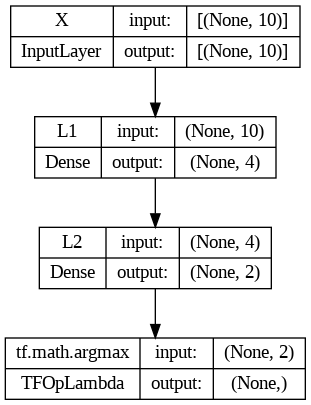

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

## 5. Load the data

First we will load the data: 60000 training images and 10000 images for validation.

In [14]:
(x_train_2d, y_train), (x_test_2d, y_test) = mnist.load_data()
x_train_2d = x_train_2d/255.0
x_test_2d = x_test_2d/255.0


print ('train: data shape', x_train_2d.shape, 'label shape', y_train.shape)
print ('test: data shape', x_test_2d.shape, 'label shape', y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
train: data shape (60000, 28, 28) label shape (60000,)
test: data shape (10000, 28, 28) label shape (10000,)


Each image is a 28x28 pixels. For this model we will interppret it as a 1D array of 784 elements. --> simplification for pictures (destroys connections of pictures)
Additionally we will use the labels a in so-called one hot encoding: each label is a vector of length 10, with all elements equal to 0, except, corresponding to the number written in the image. Let's take a look:

In [15]:
n_train = x_train_2d.shape[0]
n_test = x_test_2d.shape[0]

x_train = x_train_2d.reshape([n_train, -1])
x_test = x_test_2d.reshape([n_test, -1])

y_train_1_hot = np.zeros((n_train, y_train.max()+1))
y_train_1_hot[np.arange(n_train),y_train] = 1

y_test_1_hot = np.zeros((n_test, y_test.max()+1))
y_test_1_hot[np.arange(n_test), y_test] = 1

In [16]:
img = x_train_2d[0]
lbl = y_train[0]
lbl_1_hot = y_train_1_hot[0]


Let's check the images.

one-hot label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] . Actual label: 5


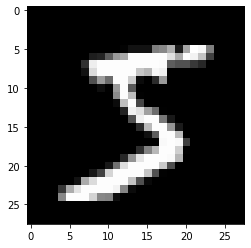

In [17]:
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.grid(False)
print('one-hot label:',lbl_1_hot, '. Actual label:', lbl )

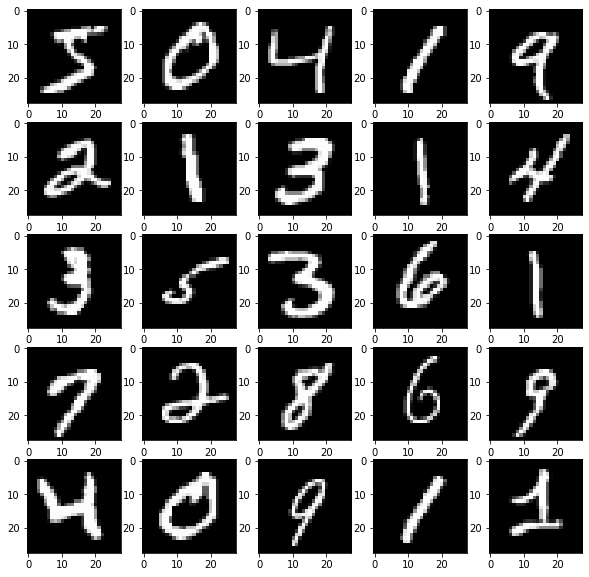

In [18]:
fig, axs = plt.subplots(5, 5, figsize=(10,10))
for idx, im in enumerate(x_train_2d[0:25]):
    y_idx = idx // 5
    x_idx = idx % 5
    axs[y_idx][x_idx].imshow(im, cmap='gray', interpolation='nearest')
    axs[y_idx][x_idx].grid(False)
plt.show()

## 6. Bulding a neural network

Number of inputs for neurons will be given by input data, i.e. image, size. Output - by number of classes, 10 in our case.

In [19]:
n_input = x_train.shape[1]
n_output = y_train_1_hot.shape[1]

Let's first build a most simple network, with just 1 layer.

In [20]:
x = tf.keras.layers.Input(name='X', dtype=tf.float32, shape=[n_input]) # this simple network is simply doing a logistic regression

# 1 layer: 768 inputs -> 10 outputs, softmax activation
l1 = tf.keras.layers.Dense(units=n_output, name='L1', activation='softmax')(x) # our model predicts probability (--> softmax)

model = tf.keras.Model(inputs=x, outputs=l1)

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model summary provides information about the model's layers and trainable parameters

In [22]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 X (InputLayer)              [(None, 784)]             0         
                                                                 
 L1 (Dense)                  (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


We will train for 5 epochs, with batches of size 64. This is very similar to what we did in last session: split all data in batches, run the optimizer, for each epoch store the training and validadtion  accuracy for plotting.

In [23]:
hist = model.fit(x=x_train, y=y_train_1_hot,
                 epochs=5, batch_size=64,
                 validation_data=(x_test, y_test_1_hot), 
                 )

Epoch 1/5
938/938 [==============================] - 3s 2ms/step - loss: 0.3677 - accuracy: 0.8960 - val_loss: 0.2865 - val_accuracy: 0.9202
Epoch 2/5
938/938 [==============================] - 2s 2ms/step - loss: 0.2883 - accuracy: 0.9188 - val_loss: 0.2791 - val_accuracy: 0.9220
Epoch 3/5
938/938 [==============================] - 2s 2ms/step - loss: 0.2775 - accuracy: 0.9227 - val_loss: 0.2868 - val_accuracy: 0.9222
Epoch 4/5
938/938 [==============================] - 2s 2ms/step - loss: 0.2702 - accuracy: 0.9245 - val_loss: 0.2916 - val_accuracy: 0.9184
Epoch 5/5
938/938 [==============================] - 2s 2ms/step - loss: 0.2671 - accuracy: 0.9260 - val_loss: 0.2765 - val_accuracy: 0.9256


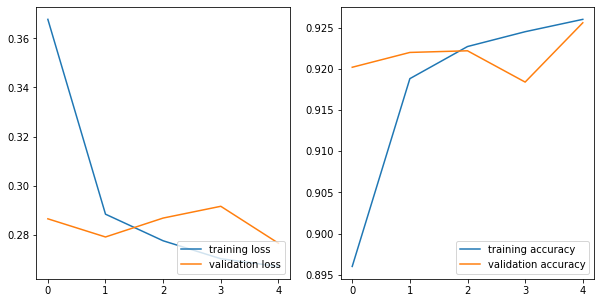

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

In [25]:
# get index of first incorrectly recognize digit and display it

test_pred = model.predict(x_test)
pred_class_idx = np.argmax(test_pred, axis=1)

correct = pred_class_idx == y_test

wrong_idx  = [i for i,c in enumerate(correct) if c == False]


313/313 [==============================] - 0s 1ms/step


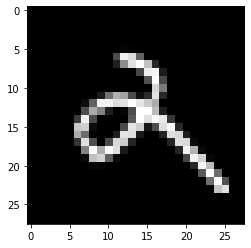

class: 2, predicted class:9


In [26]:
wrong_sample_idx = 5
sample_idx = wrong_idx[wrong_sample_idx]

plt.imshow(x_test_2d[sample_idx], cmap='gray', interpolation='nearest')
plt.show()

print(f'class: {y_test[sample_idx]}, predicted class:{pred_class_idx[sample_idx]}')

In [27]:
w1, b1 = model.get_weights()

The learned model parameters W1 are a matrix of weights that show importance of each input pixel (784) for each of the 10 outputs.

In [28]:
print(w1.shape)

(784, 10)


Let's visualize the trained weights:

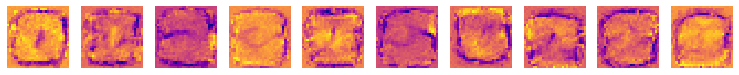

In [29]:
w1 = w1.reshape(28,28,10)
_, axs = plt.subplots(1, 10, figsize=(13,5))
for i in range(10):
    axs[i].imshow(w1[..., i], cmap='plasma', interpolation='nearest')
    axs[i].grid(False)
    axs[i].axis('off')

Here we classify images into 10 classes. But think of it: does the network know, or need to know that those were images? For the network each image is just a 784 values. And it finds that there is a patten in those!

Same way one can feed any other bunch of numbers, and the network will try it's best to fugure out a relation pannern between those.

## 7. Exercise 1

Build a network with two layers, first with `tf.nn.relu` ReLU activation and 1500 neurons and second one with 10 and softmax activation. Start with `learning_rate` of 0.001 and find optimal value.

In [84]:
x = tf.keras.layers.Input(name='X', dtype=tf.float32, shape=[n_input])

l1 = tf.keras.layers.Dense(units=1500, name='L1', activation='relu')(x)

# 2 layer:  -> 10 outputs, softmax activation
l2 = tf.keras.layers.Dense(units=n_output, name='L2', activation='softmax')(l1) # our model predicts probability (--> softmax)

model = tf.keras.Model(inputs=x, outputs= l2)

In [87]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [88]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 X (InputLayer)              [(None, 784)]             0         
                                                                 
 L1 (Dense)                  (None, 1500)              1177500   
                                                                 
 L2 (Dense)                  (None, 10)                15010     
                                                                 
Total params: 1,192,510
Trainable params: 1,192,510
Non-trainable params: 0
_________________________________________________________________


In [89]:
hist = model.fit(x=x_train, y=y_train_1_hot,
                 epochs=15, batch_size=64,
                 validation_data=(x_test, y_test_1_hot), 
                 )

Epoch 1/15
938/938 [==============================] - 13s 14ms/step - loss: 0.1939 - accuracy: 0.9413 - val_loss: 0.1270 - val_accuracy: 0.9614
Epoch 2/15
938/938 [==============================] - 13s 14ms/step - loss: 0.1040 - accuracy: 0.9691 - val_loss: 0.0896 - val_accuracy: 0.9740
Epoch 3/15
938/938 [==============================] - 15s 16ms/step - loss: 0.0760 - accuracy: 0.9777 - val_loss: 0.1074 - val_accuracy: 0.9741
Epoch 4/15
938/938 [==============================] - 16s 17ms/step - loss: 0.0647 - accuracy: 0.9809 - val_loss: 0.1043 - val_accuracy: 0.9732
Epoch 5/15
938/938 [==============================] - 13s 14ms/step - loss: 0.0516 - accuracy: 0.9847 - val_loss: 0.1146 - val_accuracy: 0.9731
Epoch 6/15
938/938 [==============================] - 13s 14ms/step - loss: 0.0488 - accuracy: 0.9866 - val_loss: 0.1277 - val_accuracy: 0.9726
Epoch 7/15
938/938 [==============================] - 13s 14ms/step - loss: 0.0444 - accuracy: 0.9878 - val_loss: 0.1397 - val_accuracy:

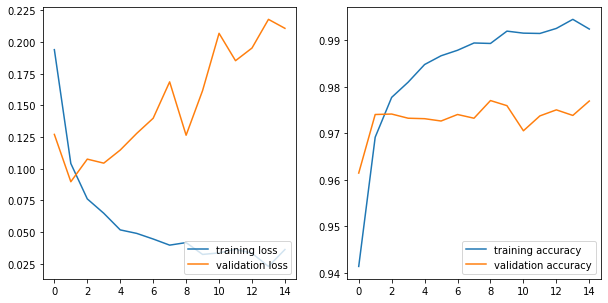

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

In [71]:
w1, b1, w2, b2 = model.get_weights()

In [72]:
print(w2.shape)

(1500, 10)


## 8. Gradients visualization

In [91]:
idx = 111
inp_v = x_train[idx:idx+1]  # use some image to compute gradients with respect to
img = x_train_2d[idx]

inp = tf.constant(inp_v)  # create tf constant tensor
with tf.GradientTape() as tape:  # gradient tape for gradint evaluation
  tape.watch(inp)  # take inp as variable
  preds = model(inp) # evaluate model output

grads = tape.jacobian(preds, inp)  # evaluate d preds[i] / d inp[j]
grads = grads.numpy().reshape(list(grads.shape)[:-1] + [28, 28])
print(grads.shape, '<- (Batch_preds, preds[i], Batch_inp, inp[y], inp[x])')
grads = grads[0,:,0]

(1, 10, 1, 28, 28) <- (Batch_preds, preds[i], Batch_inp, inp[y], inp[x])


We will display several images, and corresponding gradients of maximal output activation, as well as all activations. This might help better understand how our network processes the imput data.

prediction: 3


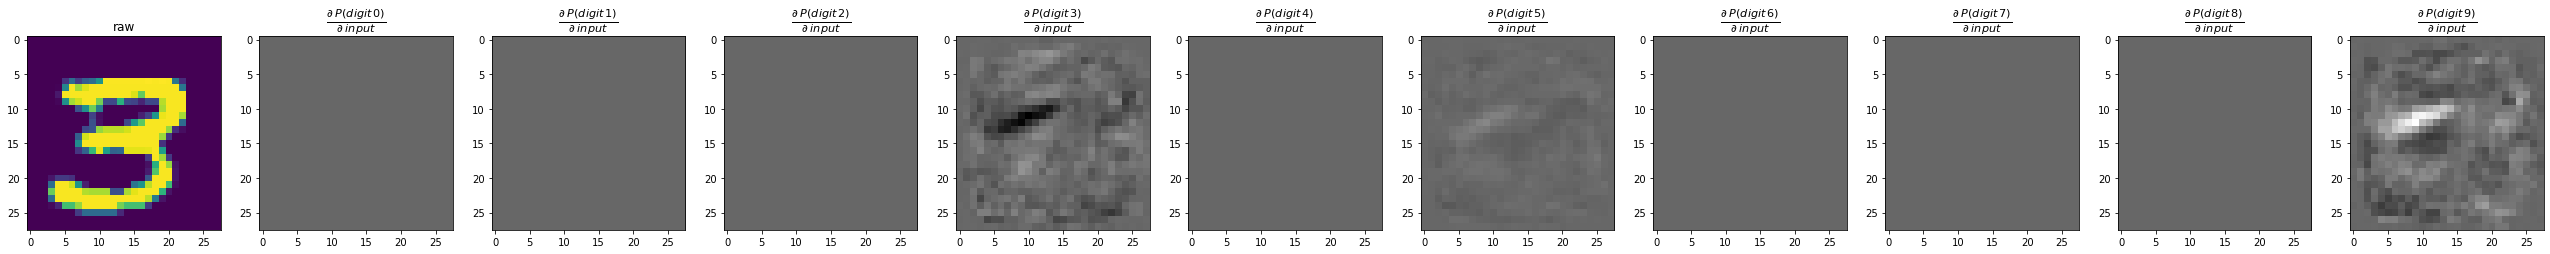

In [92]:
print('prediction:', np.argmax(preds[0]))
fig, axs = plt.subplots(1, 11, figsize=(4.1*11,4))
axs[0].imshow(img)
axs[0].set_title('raw')
vmin,vmax = grads.min(), grads.max()
for i, g in enumerate(grads):
  axs[i+1].imshow(g, cmap='gray', vmin=vmin, vmax=vmax)
  axs[i+1].set_title(r'$\frac{\partial\;P(digit\,%d)}{\partial\;input}$' % i, fontdict={'size':16})

https://medium.com/geekculture/how-visualizations-help-make-sense-of-deep-learning-a408ab00688f

## 9. Exercise 2

### Group 1

Build the network with 3 or more layers. Try to get test accuracy >98.5%.
Better to copy and modify the previous code than modyfy that one: then you can compare results.
Visualize your model.

In [ ]:
g = tf.Graph()
......
.....
...

### Group 2

You can repeat the same for a regression problem: here you will have just 1 output in the last layer, with no activation - to predict continuous unboud range. You can use the `mse` or `mae` loss. Compare results with a baseline linear / random forest model.

How many parameters does your model have as compared to number of samples?

In [93]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()

# get per-feature statistics (mean, standard deviation) from the training set to normalize by
x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

57026/57026 [==============================] - 0s 0us/step


In [94]:
print(x_test.shape)

(102, 13)


In [95]:
print(y_test.shape)

(102,)


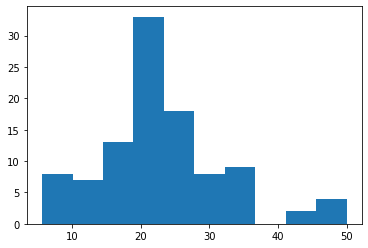

In [96]:
plt.hist(y_test);

In [ ]:
x = tf.keras.layers.Input(name='X', dtype=tf.float32, shape=[n_input])

l1 = tf.keras.layers.Dense(units=1500, name='L1', activation='relu')(x)

# 2 layer:  -> 10 outputs, softmax activation
l2 = tf.keras.layers.Dense(units=n_output, name='L2', activation='softmax')(l1) # our model predicts probability (--> softmax)

model = tf.keras.Model(inputs=x, outputs= l2)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

hist = model.fit(x=x_train, y=y_train_1_hot,
                 epochs=15, batch_size=64,
                 validation_data=(x_test, y_test_1_hot), 
                 )

whatever data --> same building blocks